# Calculate air-sea fluxes
This builds on `cm26_combine_filter_inputs.ipynb`


In [1]:
# !mamba install aerobulk-python -y

In [2]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [3]:
import json
import gcsfs
import xarray as xr


import matplotlib.pyplot as plt
import numpy as np
import os
import dask

from aerobulk import noskin
from scale_aware_air_sea.utils import open_zarr, to_zarr_split, weighted_coarsen
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.parameters import get_params

In [4]:
def compute_fluxes(
    ds,
    algo,
    method,
    sst_name = 'surface_temp',
    t_name = 't_ref',
    q_name = 'q_ref',
    u_name = 'u_relative',
    v_name = 'v_relative',
    slp_name = 'slp',
    skin_correction = False
):
    # input dependent on method
    if method == 'smooth_tracer':
        sst = ds[sst_name+'_smoothed']
        t = ds[t_name+'_smoothed']
        q = ds[q_name+'_smoothed']
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name+'_smoothed']
    elif method == 'smooth_vel':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_smoothed']
        v = ds[v_name+'_smoothed']
        slp = ds[slp_name]
    elif method == 'smooth_vel_tracer_atmos':
        sst = ds[sst_name]
        t = ds[t_name+'_smoothed']
        q = ds[q_name+'_smoothed']
        u = ds[u_name+'_smoothed_atmos_only']
        v = ds[v_name+'_smoothed_atmos_only']
        slp = ds[slp_name+'_smoothed']
    elif method == 'smooth_vel_tracer_ocean':
        sst = ds[sst_name+'_smoothed']
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_smoothed_ocean_only']
        v = ds[v_name+'_smoothed_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_vel_ocean':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_smoothed_ocean_only']
        v = ds[v_name+'_smoothed_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_all':
        sst = ds[sst_name+'_smoothed']
        t = ds[t_name+'_smoothed']
        q = ds[q_name+'_smoothed']
        u = ds[u_name+'_smoothed']
        v = ds[v_name+'_smoothed']
        slp = ds[slp_name+'_smoothed']
    elif method == 'smooth_none':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name]
    else:
        raise ValueError(f'`method`{method} not recognized')
        
    # if skin_correction:
    #     func = noskin
    
    ## test ranges on first timestep
    noskin(
        sst.isel(time=0),
        t.isel(time=0),
        q.isel(time=0),
        u.isel(time=0),
        v.isel(time=0),
        slp=slp.isel(time=0),
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=True
    )
    
    
    ds_out = xr.Dataset()
    (
        ds_out['ql'],
        ds_out['qh'],
        ds_out['taux'],
        ds_out['tauy'],
        ds_out['evap']
    ) =  noskin(
        sst,
        t,
        q,
        u,
        v,
        slp=slp,
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=False
    )
    return ds_out

In [5]:
fs = gcsfs.GCSFileSystem()

# load global parameters
params = get_params('v0.6.2', test=True)  

temp_mapper = fs.get_mapper(params['paths']['CM26']['scratch'])
mapper_smooth = fs.get_mapper(params['paths']['CM26']['smooth'])
mapper_coarse = fs.get_mapper(params['paths']['CM26']['coarse'])

mapper_smooth_fluxes = fs.get_mapper(params['paths']['CM26']['smooth_fluxes'])
mapper_coarse_fluxes = fs.get_mapper(params['paths']['CM26']['coarse_fluxes'])

In [6]:
ds_smooth = open_zarr(mapper_smooth)
ds_smooth

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 300)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [7]:
ds_coarse = open_zarr(mapper_coarse)
ds_coarse

<xarray.Dataset>
Dimensions:       (yt_ocean: 54, xt_ocean: 72, time: 300)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

In [8]:
if not fs.exists(temp_mapper.root):
    print('Recreating temp store from scratch')
    ds_merged_raw  = load_and_combine_cm26(fs, inline_array=True)

    # Only process a small dataset if the version is a test
    if 'test' in params['version']:
        ds_merged_raw = ds_merged_raw.isel(time=slice(0,300))
        
    # Try to reduce chunksize
    ds_merged_raw = ds_merged_raw.chunk({'time':1})
    
    to_zarr_split(ds_merged_raw, temp_mapper, split_interval=500)# old 150try 200 next, this is very underpowered.
    
# overwrite with reloaded store
ds_original = open_zarr(temp_mapper)
# ds_original = xr.open_dataset(temp_mapper, engine='zarr', chunks={})
ds_original

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 300)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [9]:
ds_smooth = xr.merge([ds_smooth, ds_original], join='inner')
ds_smooth

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 300)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/21)
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                              ...
    u_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean                         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind                            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [17]:
algo_options = [
    ('ncar', False), 
    ('ecmwf', False), 
    # ('coare3p0', False), 
    # ('coare3p6', False), 
    # ('andreas', False)
]

## Apply computation on smoothed_data

In [19]:
datasets = []
for (algo, skin_correction) in algo_options:
    algo_datasets = []
    for method in [
        'smooth_none', 'smooth_tracer',
        'smooth_vel', 'smooth_vel_ocean',
        'smooth_vel_tracer_ocean',
        'smooth_vel_tracer_atmos', 'smooth_all'
    ]:
        ds_method = compute_fluxes(ds_smooth, algo, method, skin_correction=skin_correction)
        ds_method = ds_method.assign_coords(smoothing=method)
        algo_datasets.append(ds_method)
    ds_algo = xr.concat(algo_datasets, dim='smoothing')
    ds_algo = ds_algo.assign_coords({'algo':f"{algo}{'_'+skin if skin_correction else ''}"})
    datasets.append(ds_algo)
ds_smooth_fluxes = xr.concat(datasets, dim='algo')
ds_smooth_fluxes

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
 

<xarray.Dataset>
Dimensions:    (yt_ocean: 2700, xt_ocean: 3600, time: 300, algo: 2, smoothing: 7)
Coordinates: (12/13)
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...         ...
  * time       (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * algo       (algo) <U5 'ncar' 'ecmwf'
Data variables:
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 1, 2700, 3600), meta=np.ndarray>
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 1, 2700, 3600), meta=np.ndarray>
    taux       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 1, 2700, 3600), meta=np.ndarray>
    tauy       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 1, 2700, 3600), meta=np.ndarray>
    evap       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 1, 2700, 3600), meta=np.ndarray>

In [22]:
roi = dict(xt_ocean=slice(-85, -75), yt_ocean=slice(20,30))

In [23]:
test = ds_smooth_fluxes.ql.isel(time=-1, algo=0).sel(smoothing='smooth_none').sel(**roi).load()

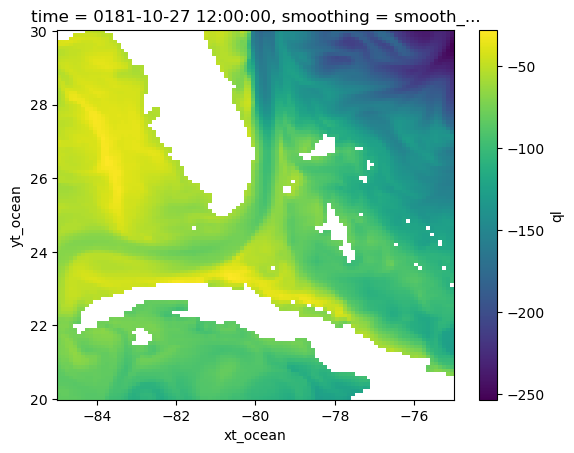

In [24]:
test.plot()

## Save out data

In [9]:
# from distributed import Client, LocalCluster

# cluster = LocalCluster(n_workers=2, threads_per_worker=2)
# client = Client(cluster)
# client

In [13]:
import subprocess
import logging
from distributed import WorkerPlugin

class MambaPlugin(WorkerPlugin):
    """
    Install packages on a worker as it starts up.

    Parameters
    ----------
    packages : List[str]
        A list of packages to install with pip on startup.
    """
    def __init__(self, packages):
        self.packages = packages

    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['mamba', 'install'] + self.packages)
        logger.info("Installed %s", self.packages)
  
## Maybe consider this if stuff is still failing? 
# dask.config.set(
#     {
#         # make sure the long running filter tasks are not timing out
#         "distributed.comm.timeouts.tcp": "1440s",
#         "distributed.comm.timeouts.connect": "1440s",
#         "distributed.deploy.lost-worker-timeout": "1440s",
#         # "distributed.scheduler.idle-timeout": "1440s"
# "distributed.scheduler.allowed-failures":10,
#     }
# )

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options.worker_memory = 52
options.worker_cores = 5
# options.worker_cores = 8 #10 would lead to some spilling)

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()

plugin = MambaPlugin(['aerobulk-python'])
client.register_worker_plugin(plugin)
# cluster.adapt(10, 200)
# cluster.scale(200)
cluster.scale(40)
client

[]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.a562578aa71249918490ab627d1cd376/status,


In [13]:
from distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33473,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:42011,Total threads: 4
Dashboard: /user/jbusecke/proxy/43991/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:36309,


### Save smoothed data

In [16]:
ds_save = ds_full
to_zarr_split(ds_save, mapper_smooth_fluxes, split_interval=300)

Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_smoothed_v0.6.2test.zarr ...


0it [00:00, ?it/s]

In [25]:
# reload the smoothed flux data
ds_reload_smooth_fluxes = open_zarr(mapper_smooth_fluxes)
ds_reload_smooth_fluxes

<xarray.Dataset>
Dimensions:    (algo: 2, yt_ocean: 2700, xt_ocean: 3600, smoothing: 7, time: 300)
Coordinates: (12/13)
  * algo       (algo) <U5 'ncar' 'ecmwf'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...         ...
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    taux       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    tauy       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

# Plots

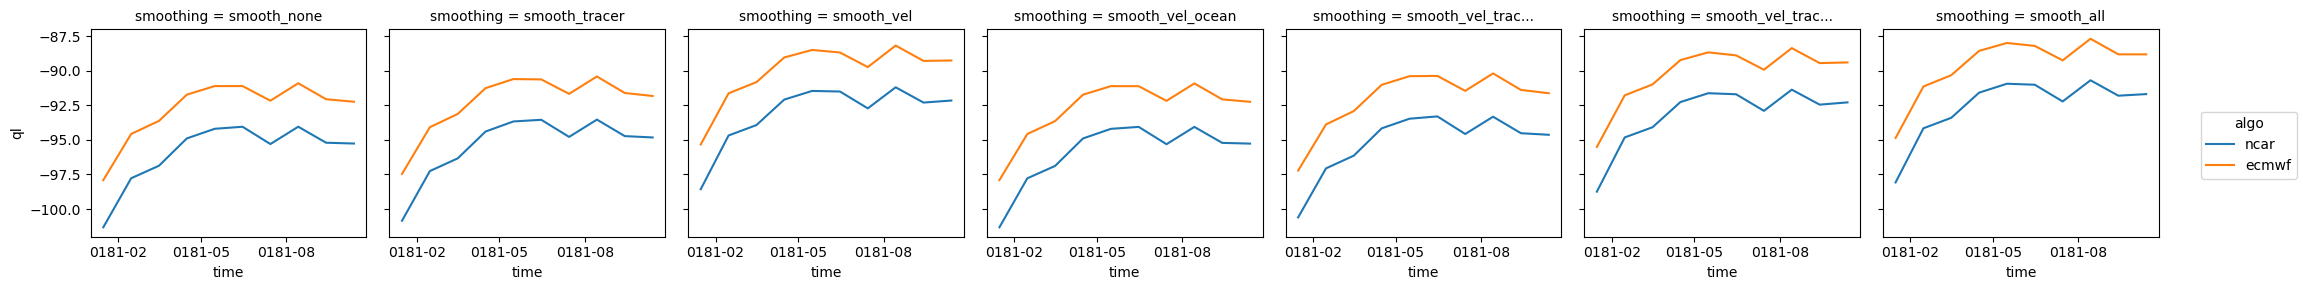

In [26]:
da_plot_smooth = ds_reload_smooth_fluxes.ql.weighted(ds_reload_smooth_fluxes.area_t).mean(['xt_ocean', 'yt_ocean']).load()
da_plot_smooth.coarsen(time=30, boundary='trim').mean().plot(hue='algo', col='smoothing')

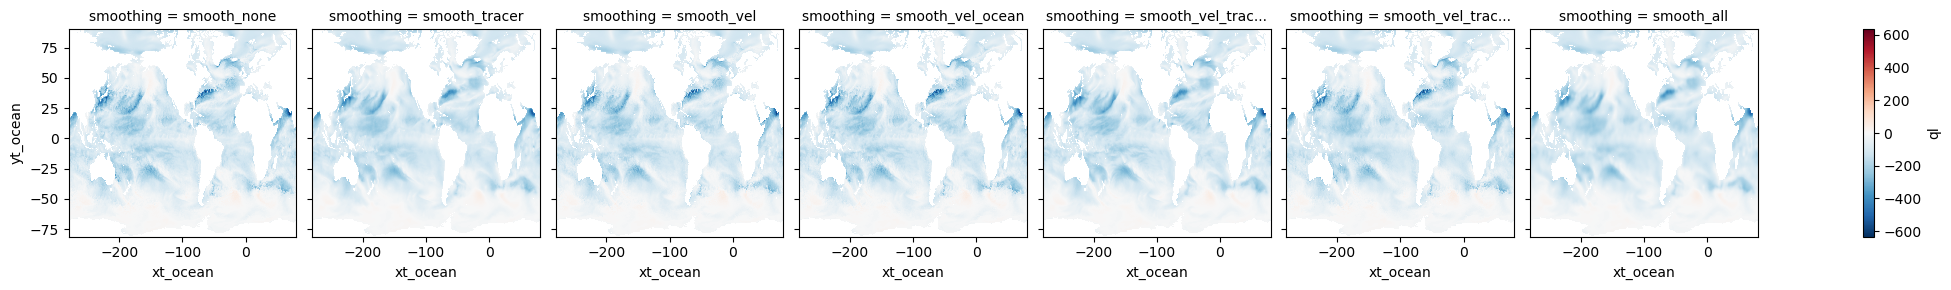

In [27]:
ds_reload_smooth_fluxes['ql'].isel(algo=0, time=0).plot(col='smoothing')

## Apply computation on coarsened data (this relies on reloaded smoothed data, specifically the smooth_none method)

In [28]:
datasets = []
# for this dataset we only have two methods
# 1. The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
# This needs to be computed over every algo
for (algo, skin_correction) in algo_options:
    # The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
    ds_coarse_single_algo = compute_fluxes(ds_coarse, algo, 'smooth_none', skin_correction=skin_correction)
    # FIXME: this naming is not really easy to understand
    # I could rename the coarsened data before? 
    ds_coarse_single_algo = ds_coarse_single_algo.assign_coords(smoothing='smooth_all')
    datasets.append(ds_coarse_single_algo)
ds_all_coarse = xr.concat(datasets, dim='algo')
# and the equivalent to smooth none, where we coarsen the full res flux output
# this is based on the other precomputed data, so all the algos are there already
ds_none_coarse = weighted_coarsen(
    ds_reload_smooth_fluxes.sel(smoothing='smooth_none'), 
    {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']},
    'area_t'
).assign_coords(smoothing='smooth_none')

# Finally concat along the 'smoothing' dimension (FIXME: better naming for this would be nice).
ds_full_coarse = xr.concat([ds_none_coarse, ds_all_coarse], dim='smoothing')
ds_full_coarse

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


<xarray.Dataset>
Dimensions:    (algo: 2, smoothing: 2, time: 300, yt_ocean: 54, xt_ocean: 72)
Coordinates:
  * algo       (algo) <U5 'ncar' 'ecmwf'
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    area_t     (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    evap       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    taux       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    tauy       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>

### Test Plots Coarsened

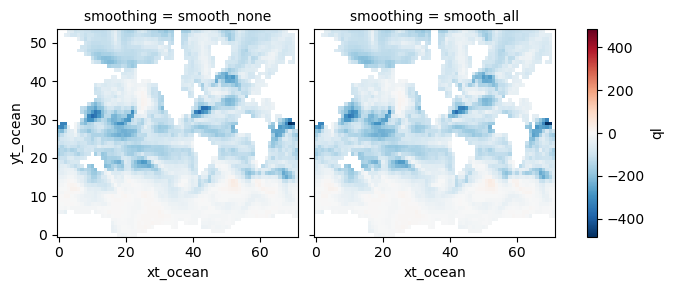

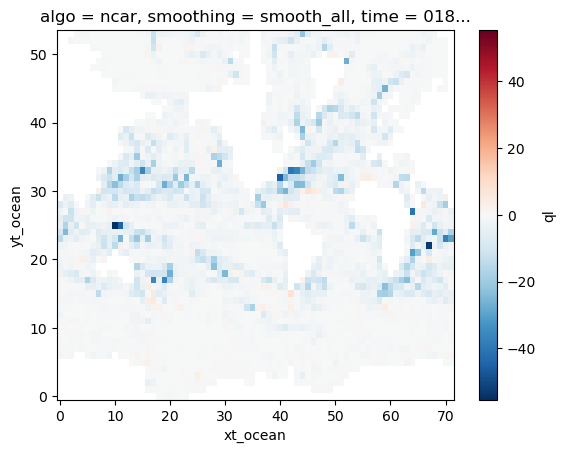

In [29]:
ds_full_coarse.ql.isel(algo=0, time=0).plot(col='smoothing')

plt.figure()
(-ds_full_coarse.ql.isel(algo=0, time=0).diff('smoothing')).plot()

### Save coarsened data

In [30]:
ds_save = ds_full_coarse
ds_save.to_zarr(mapper_coarse_fluxes, mode='w')

In [31]:
# reload the coarsened flux data
ds_reload_coarse = open_zarr(mapper_coarse_fluxes)
ds_reload_coarse

<xarray.Dataset>
Dimensions:    (algo: 2, yt_ocean: 54, xt_ocean: 72, smoothing: 2, time: 300)
Coordinates:
  * algo       (algo) <U5 'ncar' 'ecmwf'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    evap       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    taux       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    tauy       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>

#### Check missing time values

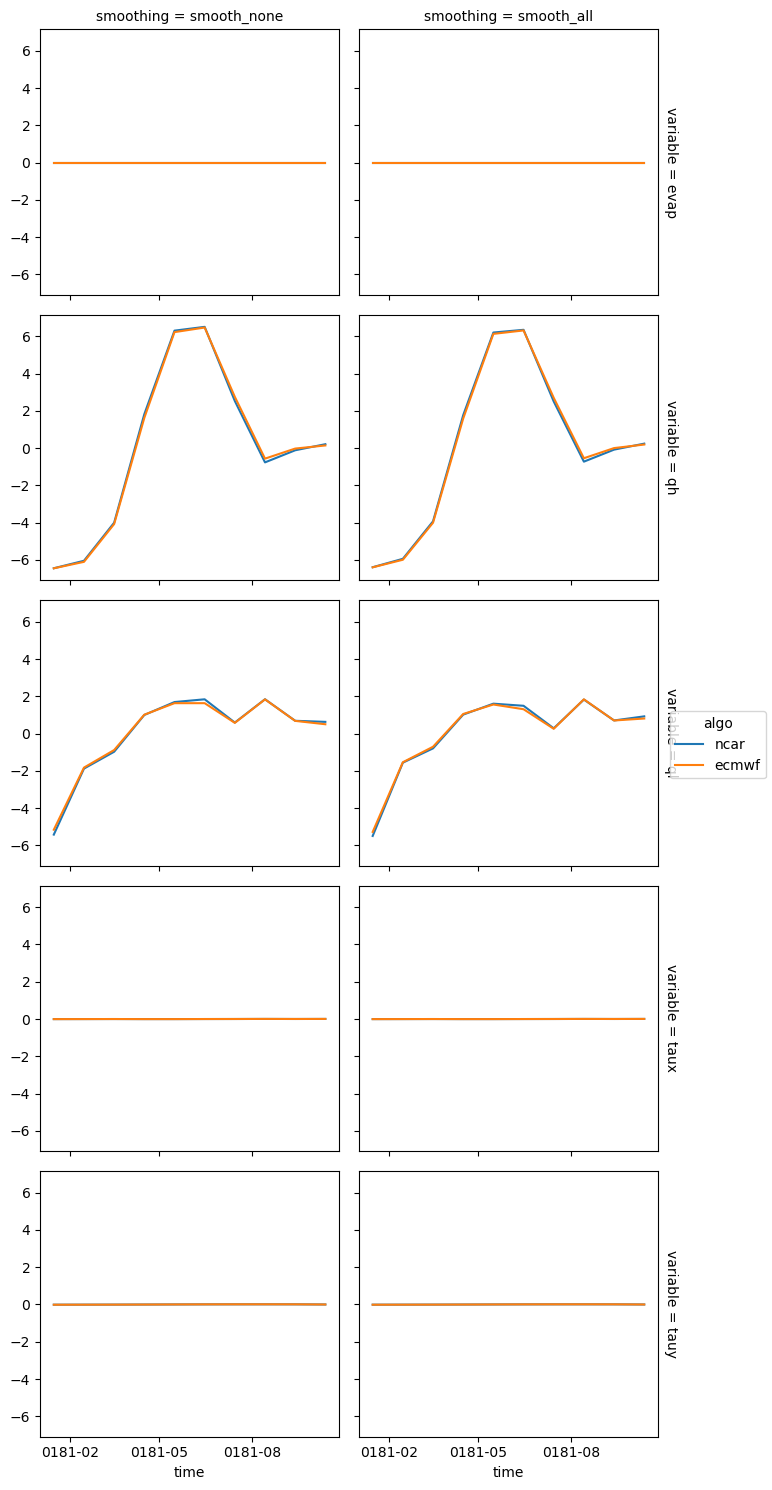

In [32]:
da_plot_coarse = ds_reload_coarse.weighted(ds_reload_coarse.area_t).mean(['xt_ocean', 'yt_ocean']).to_array().load()
(da_plot_coarse-da_plot_coarse.mean('time')).coarsen(time=30, boundary='trim').mean().plot(hue='algo', col='smoothing', row='variable')

#### Rough check on the 'small scale'
This is not really right? I should take the difference before the average...but then again, this should be linear?

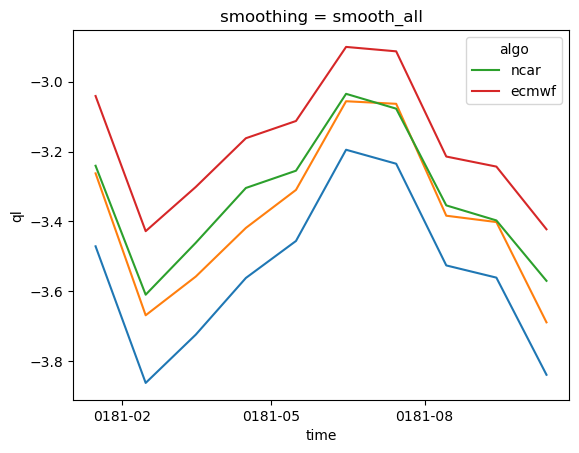

In [33]:
(-da_plot_coarse.sel(variable='ql').diff('smoothing')).coarsen(time=30, boundary='trim').mean().plot(hue='algo')
(-da_plot_smooth.sel(smoothing=['smooth_none', 'smooth_all']).diff('smoothing')).coarsen(time=30, boundary='trim').mean().plot(hue='algo')

In [23]:
# cluster.close()

In [24]:
# client.close()

2023-02-07 20:06:51,910 - distributed.client - ERROR - 
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/comm/core.py", line 291, in connect
    comm = await asyncio.wait_for(
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/tasks.py", line 445, in wait_for
    return fut.result()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/comm/tcp.py", line 511, in connect
    convert_stream_closed_error(self, e)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/comm/tcp.py", line 142, in convert_stream_closed_error
    raise CommClosedError(f"in {obj}: {exc.__class__.__name__}: {exc}") from exc
distributed.comm.core.CommClosedError: in <distributed.comm.tcp.TCPConnector object at 0x7f5f46da7bb0>: ConnectionRefusedError: [Errno 111] Connection refused

Durin